## Requirements

Please install cuda on your device if you have a GPU available.  
This line in the miniconda prompt worked for me: conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0  
You can refer to this: https://stackoverflow.com/questions/45662253/can-i-run-keras-model-on-gpu  
And also this: https://www.tensorflow.org/install/pip#linux

## Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Makes visible cuda devices, -1 otherwise

In [2]:
from helpers import *

import numpy as np

import math

import skimage.io as io
import skimage.transform as trans

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
print(f'This value has to be at most 2.10.x ---> {tf.__version__}')

This value has to be at most 2.10.x ---> 2.10.0


In [3]:
# This will print logs and cannot be disabled (except restart). Run only to check that GPU is enabled
# tf.debugging.set_log_device_placement(True)

In [4]:
# Make use of GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# with tf.device('/cpu:0'): Force CPU utilization instead of GPU
# This code should run on the GPU, you can see it by uncommenting the code in the previous cell
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

Num GPUs Available:  1
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


## Unet model

In [5]:
# Unet model from https://github.com/zhixuhao/unet/blob/master/model.py

# TODO TRY F1 AS METRIC IN MODEL.COMPILE
# TODO TRY OTHER ACTIVATION -> extract in arg of function

def unet(input_size, verbose = False):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10, name='Unet')

    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    if verbose:
        model.summary()

    return model

## Constants

In [6]:
TRAIN_DIRECTORY_PATH = './training/'
TRAIN_IMAGES_PATH = TRAIN_DIRECTORY_PATH + 'images/'
TRAIN_GROUNDTRUTH_PATH = TRAIN_DIRECTORY_PATH + 'groundtruth/'

NEW_TRAIN_DIRECTORY_PATH = './new_training/'
NEW_TRAIN_IMAGES_PATH = NEW_TRAIN_DIRECTORY_PATH + 'images/'
NEW_TRAIN_GROUNDTRUTH_PATH = NEW_TRAIN_DIRECTORY_PATH + 'groundtruth/'

TEST_DIRECTORY_PATH = './test_set_images/'
TEST_IMAGES_PATH = [TEST_DIRECTORY_PATH + "test_" + str(i) + "/" for i in range(1,51)]

PATCH_SIZE = 96
NUMBER_IMAGES_TRAINING = 100 # Not used
NUMBER_NEW_TRAINING_TO_TAKE = 50
NUMBER_CHANNELS_INPUT = 3

MODEL = unet((PATCH_SIZE, PATCH_SIZE, NUMBER_CHANNELS_INPUT), verbose = False)

RANDOM = np.random.randint(69)

tf.random.set_seed(RANDOM)

## Load data

### Train

In [7]:
train_images = []

for file in os.listdir(TRAIN_IMAGES_PATH):
    img = plt.imread(TRAIN_IMAGES_PATH + file)
    img_split = split_into_patches(img, PATCH_SIZE)
    train_images.append(img_split)

# New images
new_train_images = []
for num, file in enumerate(os.listdir(NEW_TRAIN_IMAGES_PATH)):
    if num == NUMBER_NEW_TRAINING_TO_TAKE:
        break
    img = plt.imread(NEW_TRAIN_IMAGES_PATH + file)
    img_split = split_into_patches(img, PATCH_SIZE)
    new_train_images.append(img_split)

train_images = np.array(train_images)
new_train_images = np.array(new_train_images)

# Below, this merges the first two dimensions. Instead of having x elements of y patches, we have x*y patches.
train_images = combine_dims(train_images, start = 0, count = 2)
new_train_images = combine_dims(new_train_images, start = 0, count = 2)
print(f'Base train shape: {train_images.shape}')
print(f'New train shape: {new_train_images.shape}')

# Add new training
train_images = np.concatenate((train_images, new_train_images))
print(f'Concatenated train shape: {train_images.shape}')

Base train shape: (2500, 96, 96, 3)
New train shape: (12800, 96, 96, 3)
Concatenated train shape: (15300, 96, 96, 3)


In [8]:
train_labels = []

for file in os.listdir(TRAIN_GROUNDTRUTH_PATH):
    img = plt.imread(TRAIN_GROUNDTRUTH_PATH + file)
    img_split = split_into_patches(img, PATCH_SIZE)
    train_labels.append(img_split)

# New images
new_train_labels = []
for num, file in enumerate(os.listdir(NEW_TRAIN_GROUNDTRUTH_PATH)):
    if num == NUMBER_NEW_TRAINING_TO_TAKE:
        break
    img = plt.imread(NEW_TRAIN_GROUNDTRUTH_PATH + file)
    img_split = split_into_patches(img, PATCH_SIZE)
    new_train_labels.append(img_split)
    
train_labels = np.array(train_labels)
new_train_labels = np.array(new_train_labels)

train_labels = combine_dims(train_labels, start = 0, count = 2)
new_train_labels = combine_dims(new_train_labels, start = 0, count = 2)
# Below, this adds a dimension at the end, such that the image is of size x*x*1, where 1 is the grayscale value of the pixel
train_labels = train_labels[:, :, :, np.newaxis]
new_train_labels = new_train_labels[:, :, :, np.newaxis]
print(train_labels.shape)
print(new_train_labels.shape)

# Add new training
train_labels = np.concatenate((train_labels, new_train_labels))
print(train_labels.shape)

(2500, 96, 96, 1)
(12800, 96, 96, 1)
(15300, 96, 96, 1)


### Test

In [9]:
test_images = []
test_ids = []

for directory in TEST_IMAGES_PATH:
    for file in os.listdir(directory):
        test_ids.append(file)
        img = plt.imread(directory + file)
        img_split = split_into_patches(img, PATCH_SIZE)
        test_images.append(img_split)

test_images = np.array(test_images)
# Below, this merges the first two dimensions. Instead of having x elements of y patches, we have x*y patches.
test_images = combine_dims(test_images, start = 0, count = 2)
print(test_images.shape)

test_ids = [x.split(".")[0] for x in test_ids]

(2450, 96, 96, 3)


### Split for validation

In [10]:
# TODO check other test_size fractions
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size = 0.20, random_state = RANDOM)

## Call model

In [11]:
checkpoint_path = "./check_points/unet_model"

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=7, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, save_best_only=True)]

In [12]:
MODEL.fit(X_train, y_train, batch_size=10, verbose=1, epochs=6, validation_data=(X_test, y_test), shuffle=True, callbacks=callbacks)
MODEL.save("./models/unet_model.h5")

Epoch 1/6
1224/1224 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9457
Epoch 1: val_loss improved from inf to 0.15254, saving model to ./check_points\unet_model
1224/1224 [==============================] - 93s 71ms/step - loss: 0.1952 - accuracy: 0.9457 - val_loss: 0.1525 - val_accuracy: 0.9474
Epoch 2/6
1224/1224 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9457
Epoch 2: val_loss improved from 0.15254 to 0.12923, saving model to ./check_points\unet_model
1224/1224 [==============================] - 87s 71ms/step - loss: 0.1494 - accuracy: 0.9457 - val_loss: 0.1292 - val_accuracy: 0.9474
Epoch 3/6
1224/1224 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.9455
Epoch 3: val_loss improved from 0.12923 to 0.11660, saving model to ./check_points\unet_model
1224/1224 [==============================] - 86s 70ms/step - loss: 0.1280 - accuracy: 0.9455 - val_loss: 0.1166 - val_accuracy: 0.9501
Epoch 4/6
1224/1224 [=====

### Instead of running the model you can fetch it from the file

In [13]:
loaded_model = tf.keras.models.load_model('./models/unet_model.h5')
#print(loaded_model.weights)

### Sanity checks

1/1 [==============================] - 0s 16ms/step


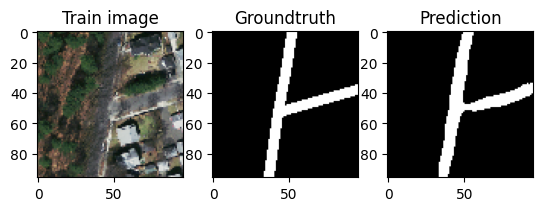

In [20]:
# TODO try other threshold for the prediction
fig, ax = plt.subplots(1,3)

ax[0].imshow(X_train[5])
ax[0].title.set_text('Train image')
ax[1].imshow(y_train[5], cmap="gray")
ax[1].title.set_text('Groundtruth')

prediction = loaded_model.predict(X_train[5][np.newaxis, :, :, :]) # Need to add an axis in front as mode expects batch
prediction = (prediction > 0.3).astype(np.uint8) # Transforms continuous values into 0-1

ax[2].imshow(prediction[0], cmap="gray")
ax[2].title.set_text('Prediction')

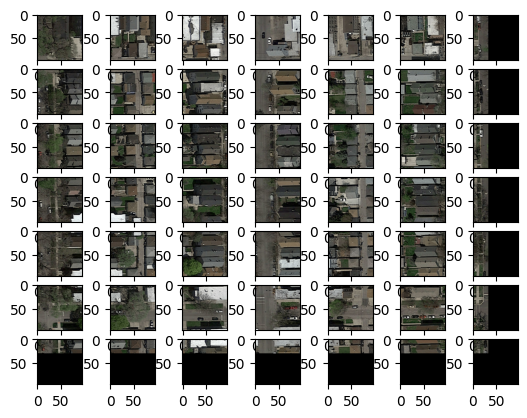

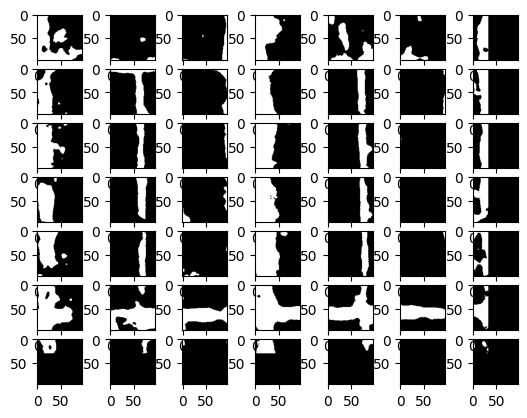

In [35]:
# TODO try other threshold for the prediction
image_you_want_to_see = 5

fig, ax = plt.subplots(7,7)
for i in range(7*image_you_want_to_see,7*image_you_want_to_see + 7):
    for j in range(7):
        ax[i-image_you_want_to_see*7,j].imshow(test_images[7*i + j])

fig1, ax1 = plt.subplots(7,7)
for i in range(7*image_you_want_to_see,7*image_you_want_to_see + 7):
    for j in range(7):
        prediction = loaded_model.predict(test_images[7*i + j][np.newaxis, :, :, :], verbose = False)
        prediction = (prediction > 0.2).astype(np.uint8)
        ax1[i-image_you_want_to_see*7,j].imshow(prediction[0], cmap='gray')

## Save submission

In [36]:
test_predictions = loaded_model.predict(test_images)

77/77 [==============================] - 7s 65ms/step


In [40]:
# TODO THRESHOLD CHANGE
submission = []
# The constants with _SIDE mean how many patches fit per image in one dimension (one side)
TEST_IMAGE_LENGTH = 608
PATCHES_PER_IMAGE_SIDE = math.ceil(TEST_IMAGE_LENGTH/PATCH_SIZE)
PATCHES_PER_IMAGE = PATCHES_PER_IMAGE_SIDE**2
SUBIMAGES_PER_PATCH_SIDE = PATCH_SIZE/16
for i, pred in enumerate(test_predictions):
    img_id = test_ids[i//PATCHES_PER_IMAGE]
    # Format the image id
    id = img_id.split('_')[1].zfill(3)
    # Make sure the patch size is a multiple of 16 otherwise this line won't work
    preds = split_into_patches(pred, 16)
    for j, img in enumerate(preds):
        # Calculate the index of each subimage (in terms of pixels)
        x = 16*(SUBIMAGES_PER_PATCH_SIDE*((i % PATCHES_PER_IMAGE) % PATCHES_PER_IMAGE_SIDE) + j % SUBIMAGES_PER_PATCH_SIDE)
        y = 16*(SUBIMAGES_PER_PATCH_SIDE*((i % PATCHES_PER_IMAGE) // PATCHES_PER_IMAGE_SIDE) + j // SUBIMAGES_PER_PATCH_SIDE)
        # Don't add the padding predictions
        if x < TEST_IMAGE_LENGTH and y < TEST_IMAGE_LENGTH:
            # For now we calculate the average over all the pixels and check if it's above 0.5
            submission.append((f"{id}_{x:.0f}_{y:.0f}", 1 if img.mean() > 0.2 else 0))
np.savetxt("predictions.csv", np.asarray(submission), fmt="%s", delimiter=",", newline="\n", header="id,prediction", comments="")